Import the required packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Using Python to fit models to data

This notebook describes various methods to fit a function to a set of data points using Python. There are a number of available methods, each with different fitting algoritms and results. The most appropriate method to use depends on the objective of the code. To illustrate the differences it will be shown how the various methods can be applied to fit a straight line to some data points, which are generated in the code cell below. To add noise to the data, the `normal` function from `numpy.random` is used, which takes a keyword argument `scale`, which is the standard deviation of the normal probability distribution. The `size` argument determines the number of randomly-drawn samples.

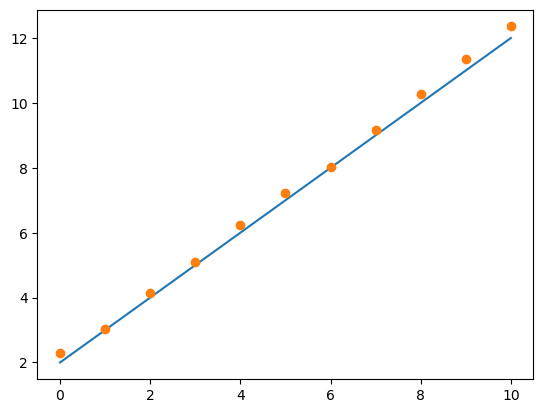

In [2]:
x = np.linspace(0, 10, 11)
intercept = 2.0
slope = 1.0
y = intercept + slope * x
ydata = y + np.random.normal(scale=0.25, size=len(x))

# Plot the straight line as well as the data points
plt.plot(x, y)
plt.plot(x, ydata, 'o');

When fitting the volume - water level relationship for the farm dam water balance study, we used the `polyfit` function. It can be used to fit a straight line as well by specifying the degree of the polynomial as one (`deg=1`). The return value of the function is an array with the coefficients of the polynomial, with the slope being the first element of the array and the intercept the second. Remember that a function can be created using the `poly1d` method, which takes the coefficiens as arguments. The graph below is the same as the previous graph except that it now includes the line (blue dashes) based on the fitted coefficient.

[1.01757861 2.11381792]


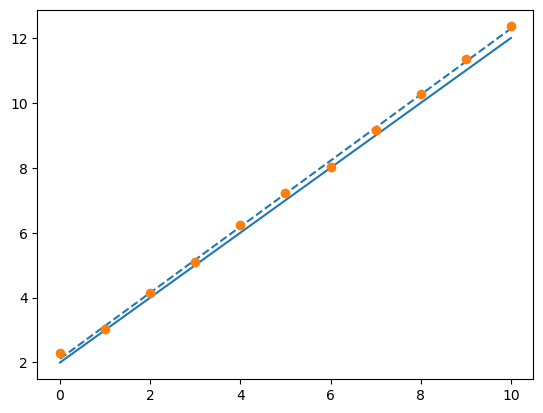

In [3]:
pcoef = np.polyfit(x=x, y=ydata, deg=1)
print(pcoef)
pfunc = np.poly1d(pcoef)

ypoly = pfunc(x)

plt.plot(x, y)
plt.plot(x, ypoly, 'C0--')
plt.plot(x, ydata, 'o');

There is also a function in `scipy.stats` called  `linregress`. This function returns additional information, such as the $r$ value (indicating the goodness of fit) and the standard errors of the fitted slope and intercept.

LinregressResult(slope=1.0175786052293359, intercept=2.1138179222305276, rvalue=0.9995863214149351, pvalue=3.4845037663409182e-15, stderr=0.009759509840951662, intercept_stderr=0.05773803886301588)

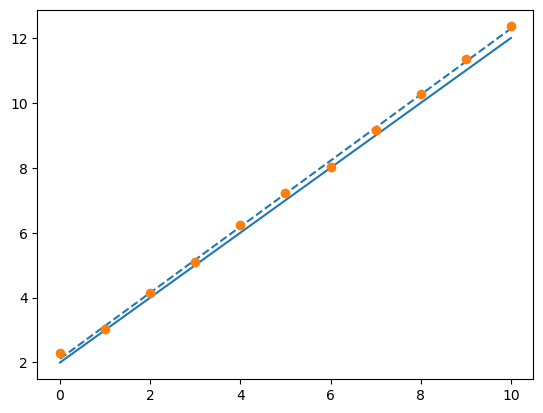

In [4]:
from scipy.stats import linregress

res = linregress(x=x, y=ydata)
slope = res.slope
intercept = res.intercept

ylr = intercept + slope * x

plt.plot(x, y)
plt.plot(x, ylr, 'C0--')
plt.plot(x, ydata, 'o')

res

For math afficionados, there is also the `lstsq` method in `np.linalg`. The return value of this function is $x$ in 

<p align="center">
<img src="screenshot_matrix_equations.png" alt="matrix equations" height="400">
</p>

The function returns $x$, the residuals as well as the rank (number of independent columns in $x$) and singular values of $A$.

(array([1.01757861, 2.11381792]),
 array([0.09429555]),
 2,
 array([19.82222229,  1.75485139]))

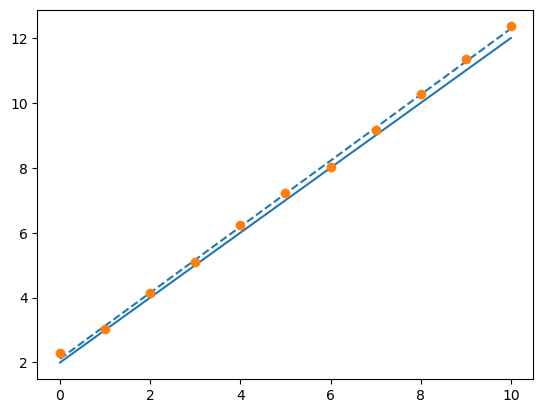

In [5]:
A = np.ones((len(x), 2))
A[:, 0] = x
res = np.linalg.lstsq(A, ydata, rcond=None) # rcond is a parameter related to the calculation of the rank
slope, intercept = res[0]

ylstsq = intercept + slope * x
plt.plot(x, y)
plt.plot(x, ylstsq, 'C0--')
plt.plot(x, ydata, 'o')

res

The function `minimize` from the `scipy.optimize` library finds the minimum of an objective function, in this case `fdiff`, which returns the sum of squared residuals. The parameters to be optimized are passed as the array `p`. For the `minimize` function, the user must also specify starting guesses of the parameters in `p` using the `x0` keyword argument. Because the function `fdiff` does not only take `p` as an argument, but also `x` and `ydata`, it is necessary to specify this using the `args` keyword argument.

The optimzed parameter values are stored in `x` of the return value. The function `minimize` also calculates the Jacobian matrix, which provides information about the parameter sensitivities. See <A href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html">https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html</A> for details.

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.09429555201221831
        x: [ 2.114e+00  1.018e+00]
      nit: 2
      jac: [ 4.862e-07  7.890e-06]
 hess_inv: [[ 9.822e-01 -1.416e-01]
            [-1.416e-01  2.171e-02]]
     nfev: 15
     njev: 5

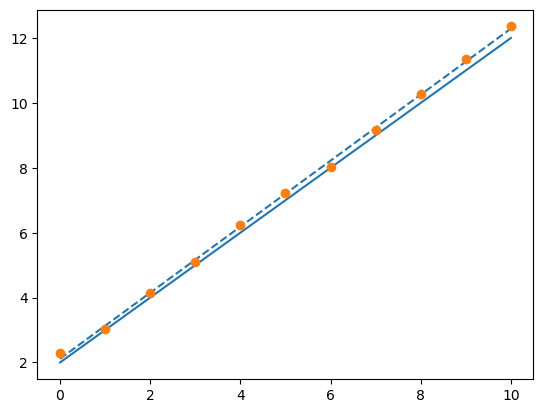

In [6]:
from scipy.optimize import minimize

def fdiff(p, x, ydata):
    intercept = p[0]
    slope = p[1]
    y = intercept + slope * x
    return np.sum((y - ydata)  ** 2)

res = minimize(fdiff, x0=[0, 1], args=(x, ydata))

intercept = res.x[0]
slope = res.x[1]

ym = intercept + slope * x
plt.plot(x, y)
plt.plot(x, ym, 'C0--')
plt.plot(x, ydata, 'o')

res

The `lmfit` package provides a range of non-linear least-squares minimization and curve-fitting functions for Python. It extends the methods of ` scipy.optimize` and provides some of the functionality that PEST also provides. In the code cell below, a similar objective function is provided as the one used before (except that it does not return the sum of squared residuals but simply the residuals). The parameters are stored in an instance of the `Parameters` class and are added using the `add` method. Note that not only the initial guesses are defined using `add` but it is also possible to define minimum and maximum parameter bounds.

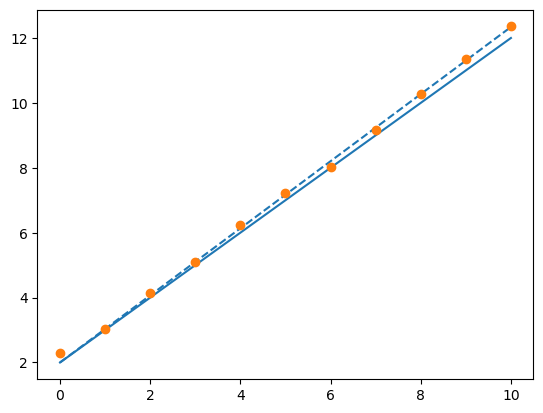

In [7]:
import lmfit

def fdiff(p, x, ydata):
    intercept = p["intercept"]
    slope = p["slope"]
    y = intercept + slope * x
    return y - ydata

parameters = lmfit.Parameters()
parameters.add('intercept', value=0, min=-2.0, max=2.0)
parameters.add('slope', value=1.0, min=0.1, max=3.0)
mini = lmfit.Minimizer(userfcn=fdiff,
                       fcn_args=(x, ydata),
                       calc_covar=True,
                       params=parameters)
res = mini.minimize(method="leastsq")

intercept = res.params["intercept"]
slope = res.params["slope"]

ylmfit = intercept + slope * x
plt.plot(x, y)
plt.plot(x, ylmfit, 'C0--')
plt.plot(x, ydata, 'o')

res

To demonstrate how a parameter value can be held constant during the optimization, we rerun the previous example, but now we force the intercept through zero (using `vary=False` for the intercept).

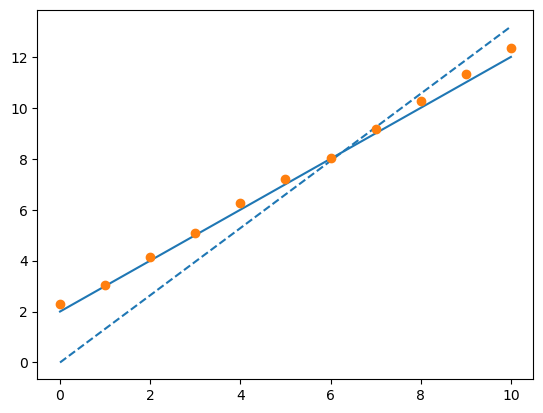

In [8]:
parameters = lmfit.Parameters()
parameters.add('intercept', value=0, vary=False)
parameters.add('slope', value=1.0, min=0.1, max=3.0)
mini = lmfit.Minimizer(userfcn=fdiff,
                       fcn_args=(x, ydata),
                       calc_covar=True,
                       params=parameters)
res = mini.minimize(method="leastsq")

intercept = res.params["intercept"]
slope = res.params["slope"]

ylmfit = intercept + slope * x

plt.plot(x, y)
plt.plot(x, ylmfit, 'C0--')
plt.plot(x, ydata, 'o')

res

***Exercise***: The array `ydata` defines a set of $y$ values of $y = A\ sin(b x)$ for the $x$ values in `xdata`. Rewrite the function `fdiff` and modify the lmfit function calls to fit find the values of $A$ and $b$ that fit the data points. Be warned that your initial guess has an extreme influence on the result!

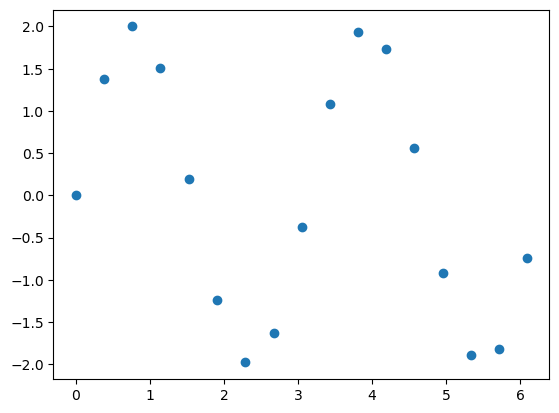

In [11]:
xdata = np.array([0.0, 0.38, 0.76, 1.14, 1.52, 1.9, 2.28, 2.67, 3.05, 3.43, 3.81, 4.19, 4.57, 4.95, 5.33, 5.71, 6.09])
ydata = np.array([0.0, 1.38, 2.0, 1.51, 0.19, -1.24, -1.98, -1.63, -0.38, 1.08, 1.94, 1.73, 0.56, -0.92, -1.89, -1.82, -0.74])

plt.plot(xdata, ydata, 'o')

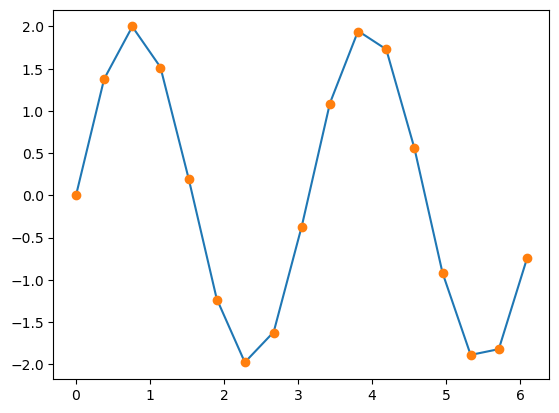

In [10]:
import lmfit


def fdiff(p, xdata, ydata):
    intercept = p["intercept"]
    teta = p["teta"]
    y = np.sin(teta * xdata)*intercept
    return y - ydata

parameters = lmfit.Parameters()
parameters.add('intercept', value=10)
parameters.add('teta', value=1.0)
mini = lmfit.Minimizer(userfcn=fdiff,
                       fcn_args=(xdata, ydata),
                       calc_covar=True,
                       params=parameters)
res = mini.minimize(method="leastsq")

intercept = res.params["intercept"]
slope = res.params["teta"]

y = intercept * np.sin(slope * xdata)
plt.plot(xdata, y)
plt.plot(xdata, ydata, 'o')

res

For more information on linear regression on Python see <A href="https://realpython.com/linear-regression-in-python/">https://realpython.com/linear-regression-in-python/</A>.